In [2]:
from IPython.display import clear_output
from google.colab import files
files.upload()
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d darthvader4067/hideblur
!unzip hideblur.zip
!rm hideblur.zip
!cd HIDE_dataset && mv GT ../
!cd HIDE_dataset && mv train ../
!rm -rf HIDE_dataset
clear_output()

In [3]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms as T
import torch.autograd as autograd

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
import functools
from functools import partial

In [4]:
blurred = glob('train' + '/*.png')
sharp = glob('GT' + '/*.png')

blurred_name = sorted([str(x) for x in blurred])
sharp_name = sorted([str(x) for x in sharp])

blurred_idx = [int(str(x).replace('.MP4', '').split('fromGOPR')[-1].split('.')[0]) for x in blurred_name]
sharp_idx = [int(str(x).replace('.MP4', '').split('fromGOPR')[-1].split('.')[0]) for x in sharp_name]

existing_idx = np.nonzero(np.isin(sharp_idx, blurred_idx))[0]
sharp_name = np.array(sharp_name)

df = pd.DataFrame(data={'blur': blurred_name, 'sharp': sharp_name[existing_idx]})
df.sample(5)

,blur,sharp
175,train/107fromGOPR1080.MP4.png,GT/107fromGOPR1080.MP4.png
3486,train/244fromGOPR1084.MP4.png,GT/244fromGOPR1084.MP4.png
6300,train/96fromGOPR1095.MP4.png,GT/96fromGOPR1095.MP4.png
3914,train/267fromGOPR1081.MP4.png,GT/267fromGOPR1081.MP4.png
4020,train/272fromGOPR1080.MP4.png,GT/272fromGOPR1080.MP4.png


In [5]:
train, valid = train_test_split(df, test_size=500, shuffle=True, random_state=123)
train.shape, valid.shape

((5897, 2), (500, 2))

In [6]:
torch.random.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)

BATCH_SIZE = 16  # when batch_size is not very small use batch_norm instead instance_norm
IMAGE_HEIGHT = 640
IMAGE_WIDTH = 360
epochs = 50
FINE_SIZE = 256
gp_lambda = 10
content_loss_lambda = 100

PATH = r'/content/drive/My Drive/data/deblur_model.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((FINE_SIZE, FINE_SIZE)), #, Image.BICUBIC),
                              T.RandomHorizontalFlip(p=0.2),
                              T.ToTensor(),
                              T.Normalize(0.5, 0.5),
])
valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((FINE_SIZE, FINE_SIZE)), # Image.BICUBIC),
                              T.ToTensor(),
                              T.Normalize(0.5, 0.5),
])

In [8]:
class BlurDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        row = self.df.iloc[ix].squeeze()
        blurred_img = cv2.imread(row['blur'])
        blurred_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB)
        sharp_img = cv2.imread(row['sharp'])
        sharp_img = cv2.cvtColor(sharp_img, cv2.COLOR_BGR2RGB)
        return blurred_img, sharp_img

    def collate_fn(self, batch):
        blurs, sharps = list(zip(*batch))
        blurs = [self.transforms(img)[None] for img in blurs]
        sharps = [self.transforms(img)[None] for img in sharps]
        blurs, sharps = [torch.cat(i).to(device) for i in [blurs, sharps]]
        return blurs, sharps

In [9]:
train_dataset = BlurDataset(train, transforms=train_transforms)
valid_dataset = BlurDataset(valid, transforms=valid_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=True, collate_fn=valid_dataset.collate_fn)

In [10]:
def get_norm_layer(layer_type='batch'):
    if layer_type == 'batch':
        return nn.BatchNorm2d
    else:
        return partial(nn.InstanceNorm2d, track_running_stats=False)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1, 0.02)
        nn.init.zeros_(m.bias)

class ResNetBlock(nn.Module):
    def __init__(self, dim, norm_layer, use_bias, dropout=False):
        super(ResNetBlock, self).__init__()
        sequence = list()

        sequence += [nn.ReflectionPad2d(1)]

        sequence += [
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0, bias=use_bias),
            norm_layer(dim),
            nn.ReLU(True)
        ]
        if dropout:
            sequence += [nn.Dropout(0.5)]

        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        out = x + self.model(x)
        return out

class Generator(nn.Module):

    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9, norm_type='batch'):
        super(Generator, self).__init__()

        norm_layer = get_norm_layer(norm_type)
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func != nn.BatchNorm2d
        else:
            use_bias = norm_layer != nn.BatchNorm2d

        sequence = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, stride=1, padding=0, bias=use_bias),
            norm_layer(ngf),
            nn.ReLU(True)
        ]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            sequence += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                norm_layer(ngf * mult * 2),
                nn.ReLU(True)
            ]

        for i in range(n_blocks):
            sequence += [
                ResNetBlock(ngf * 2 ** n_downsampling, norm_layer, use_bias)
            ]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            sequence += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1,
                                   output_padding=1, bias=use_bias),
                norm_layer(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]

        sequence += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        out = self.model(x)
        out = x + out
        out = torch.clamp(out, min=-1, max=1)
        return out

class Discriminator(nn.Module):

    def __init__(self, input_nc, ndf=64, n_layers=3, use_sigmoid=False, norm_type='batch'):
        super(Discriminator, self).__init__()

        norm_layer = get_norm_layer(norm_type)
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func != nn.BatchNorm2d
        else:
            use_bias = norm_layer != nn.BatchNorm2d

        kernel_size = 4
        padding = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kernel_size, stride=2, padding=padding),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.utils.spectral_norm(nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kernel_size, stride=2, padding=padding,
                          bias=use_bias), n_power_iterations=2),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True),
                nn.Dropout(0.5)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.utils.spectral_norm(nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kernel_size, stride=1, padding=padding,
                      bias=use_bias), n_power_iterations=2),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.5)
        ]

        sequence += [
            nn.Conv2d(ndf * nf_mult, 1, kernel_size=kernel_size, stride=1, padding=padding)
        ]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        out = self.model(x)
        return out

In [11]:
generator = Generator(3, 3, n_blocks=9).apply(init_weights).to(device)
discriminator = Discriminator(3).apply(init_weights).to(device)

CONV3_3_IN_VGG_19 = torchvision.models.vgg19(pretrained=True, progress=False).features[:15].to(device)

In [12]:
from torchsummary import summary

summary(generator, (3, FINE_SIZE, FINE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,408
       BatchNorm2d-3         [-1, 64, 256, 256]             128
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,728
       BatchNorm2d-6        [-1, 128, 128, 128]             256
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         294,912
       BatchNorm2d-9          [-1, 256, 64, 64]             512
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         589,824
      BatchNorm2d-13          [-1, 256, 64, 64]             512
             ReLU-14          [-1, 256,

In [13]:
summary(discriminator, (3, FINE_SIZE, FINE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,152
      BatchNorm2d-10          [-1, 512, 31, 31]           1,024
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,765,633
Trainable params: 2,765,633
Non-trainable params: 0
---------------------------

In [14]:
summary(CONV3_3_IN_VGG_19, (3, FINE_SIZE, FINE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [15]:
def load_model(path, device=device):
    if device == 'cuda':
        checkpoint = torch.load(path)
    else:
        checkpoint = torch.load(path, map_location=torch.device('cpu'))
    epoch = checkpoint['epoch']
    generator = checkpoint['G']
    discriminator = checkpoint['D']
    optimizerG = checkpoint['optimizerG']
    optimizerD = checkpoint['optimizerD']
    return generator, discriminator, optimizerG, optimizerD, epoch

def PSNR(deblurred, sharp):
    mse = torch.mean((deblurred - sharp) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    return 10 * np.log10(PIXEL_MAX ** 2 / mse)

class WGANLoss(nn.Module):
    def forward(self, mtype, **kwargs):
        if mtype == 'G':
            deblurred_discriminator_out = kwargs['deblurred_discriminator_out']
            return -deblurred_discriminator_out.mean()

        elif mtype == 'D':  
            gp_lambda = kwargs['gp_lambda']
            interpolates = kwargs['interpolates']
            interpolates_discriminator_out = kwargs['interpolates_discriminator_out']
            sharp_discriminator_out = kwargs['sharp_discriminator_out']
            deblurred_discriminator_out = kwargs['deblurred_discriminator_out']

            wgan_loss = deblurred_discriminator_out.mean() - sharp_discriminator_out.mean()

            gradients = autograd.grad(outputs=interpolates_discriminator_out, inputs=interpolates,
                                      grad_outputs=torch.ones(interpolates_discriminator_out.size()).to(device),
                                      retain_graph=True,
                                      create_graph=True)[0]
            gradient_penalty = ((gradients.view(gradients.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()

            return wgan_loss, gp_lambda * gradient_penalty

class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def forward(self, deblurred, sharp, model=CONV3_3_IN_VGG_19):
        model.eval()
        deblurred = (deblurred + 1) * 0.5
        sharp = (sharp + 1) * 0.5

        deblurred = nn.functional.interpolate(deblurred, mode='bilinear', size=(224, 224), align_corners=False)
        sharp = nn.functional.interpolate(sharp, mode='bilinear', size=(224, 224), align_corners=False)

        deblurred, sharp = [[self.normalize(img)[None] for img in imgs] for imgs in [deblurred, sharp]]
        deblurred, sharp = [torch.cat(i) for i in [deblurred, sharp]]

        deblurred_feature_map = model.forward(deblurred)
        sharp_feature_map = model.forward(sharp).detach()
        loss = nn.functional.mse_loss(deblurred_feature_map, sharp_feature_map)

        return loss

def simple_gan_loss(mtype, **kwargs):
    if mtype == 'G':
        deblurred_discriminator_out = kwargs['deblurred_discriminator_out']
        return nn.functional.binary_cross_entropy(deblurred_discriminator_out, torch.ones_like(deblurred_discriminator_out))

    elif mtype == 'D':
        sharp_discriminator_out = kwargs['sharp_discriminator_out']
        deblurred_discriminator_out = kwargs['deblurred_discriminator_out']
        real_loss = nn.functional.binary_cross_entropy(sharp_discriminator_out, torch.ones_like(sharp_discriminator_out))
        fake_loss = nn.functional.binary_cross_entropy(deblurred_discriminator_out, torch.zeros_like(deblurred_discriminator_out))
        return (real_loss + fake_loss) / 2.0

In [16]:
criterion_wgan = WGANLoss()
criterion_content = ContentLoss()

optimizerG = torch.optim.AdamW(generator.parameters(), lr=0.0001, betas=(0.5, 0.999), amsgrad=True, weight_decay=0.)
optimizerD = torch.optim.AdamW(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999), amsgrad=True, weight_decay=0.)

#optimizerG = torch.optim.AdamW(generator.parameters(), lr=1e-4, betas=(0., 0.9))
#optimizerD = torch.optim.AdamW(discriminator.parameters(), lr=1e-4, betas=(0., 0.9), weight_decay=1e-3)

#lr_lambda = lambda epoch: (1 - (epoch - 150) / 150) if epoch > 150 else 1
#schedulerG = torch.optim.lr_scheduler.LambdaLR(optimizerG, lr_lambda=lr_lambda)
#schedulerD = torch.optim.lr_scheduler.LambdaLR(optimizerD, lr_lambda=lr_lambda)

In [17]:
def denormalize(image_tensor):
    return (image_tensor + 1) / 2.0

def train_one_batch(generator, discriminator, data, criterionW, criterionC, optimizerG, optimizerD, critic_updates=5):
    generator.train()
    discriminator.train()

    blur, sharp = data

    discriminator_loss = 0
    for param in discriminator.parameters():
        param.requires_grad = True

    for _ in range(critic_updates):

        deblur = generator(blur)

        d_sharp_out = discriminator(sharp)
        d_deblur_out = discriminator(deblur)

        optimizerD.zero_grad()
        alpha = np.random.random()
        interpolates = alpha * sharp + (1 - alpha) * deblur
        interpolates_discriminator_out = discriminator(interpolates)
        kwargs = {
                  'gp_lambda': gp_lambda,
                  'interpolates': interpolates, 
                  'interpolates_discriminator_out': interpolates_discriminator_out, 
                  'sharp_discriminator_out': d_sharp_out, 
                  'deblurred_discriminator_out': d_deblur_out,  
                  }
        wgan_loss_d, gp_d = criterionW('D', **kwargs)
        discriminator_loss_per_update = wgan_loss_d + gp_d
        discriminator_loss_per_update.backward(retain_graph=critic_updates>1)
        optimizerD.step()
        discriminator_loss += discriminator_loss_per_update.item()
    discriminator_loss /= critic_updates

    for param in discriminator.parameters():
        param.requires_grad = False
    optimizerG.zero_grad()
    
    deblur = generator(blur)
    d_deblur_out = discriminator(deblur)
    
    kwargs = {
              'deblurred_discriminator_out': d_deblur_out, 
              }    
    wgan_loss_g = criterionW('G', **kwargs)
    content_loss_g = criterionC(deblur, sharp) * content_loss_lambda
    generator_loss = wgan_loss_g + content_loss_g
    generator_loss.backward()
    optimizerG.step()

    with torch.no_grad():
        denormalized_sharp = denormalize(sharp).cpu().detach()
        denormalized_deblurred = denormalize(deblur).cpu().detach()

    metric = PSNR(denormalized_deblurred, denormalized_sharp)

    return discriminator_loss, generator_loss.item(), metric

@torch.no_grad()
def validate(generator, discriminator, data, criterionW, criterionC):
    generator.eval()
    discriminator.eval()

    blur, sharp = data
    deblur = generator(blur)
    d_deblur = discriminator(deblur)

    kwargs = {
              'deblurred_discriminator_out': d_deblur, }
    adversarial_loss_g = criterionW('G', **kwargs)
    content_loss_g = criterionC(deblur, sharp) * content_loss_lambda
    loss_g = adversarial_loss_g + content_loss_g

    denormalized_sharp = denormalize(sharp).cpu().detach()
    denormalized_deblurred = denormalize(deblur).cpu().detach()

    metric = PSNR(denormalized_deblurred, denormalized_sharp)

    return loss_g.item(), metric

@torch.no_grad()
def visual_validate(data, model):
    img, tar = data
    model.eval()
    out = model(img)
    out, img, tar = [denormalize(tensor) for tensor in [out, img, tar]]
    out, img, tar = [tensor.squeeze().cpu().detach().numpy().transpose(1,2,0) for tensor in [out, img, tar]]
    plt.figure(figsize=(12,14))
    plt.subplot(131)
    plt.title('Blurred')
    plt.imshow(img)
    plt.subplot(132)
    plt.title('Target')
    plt.imshow(tar)
    plt.subplot(133)
    plt.title('Deblurred')
    plt.imshow(out)
    plt.show()
    plt.pause(0.001)

In [18]:
# generator, discriminator, optimizerG, optimizerD, ep = load_model(PATH)

Epoch 1/50


  0%|          | 0/369 [00:00<?, ?it/s]

Train D loss: 227.9416, train G loss: 4892.6556
Train metric: 14.0663


  0%|          | 0/500 [00:00<?, ?it/s]

Valid G loss: 2780.6069
Valid metric: 19.2939
--------------------------------------------------
Epoch 2/50


  0%|          | 0/369 [00:00<?, ?it/s]

Train D loss: 7.0356, train G loss: 4577.2984
Train metric: 14.8372


  0%|          | 0/500 [00:00<?, ?it/s]

Valid G loss: 2708.6348
Valid metric: 20.2478
--------------------------------------------------


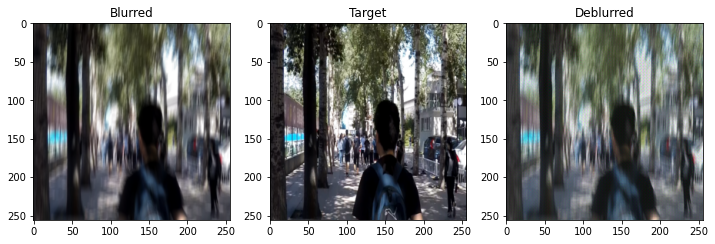

  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 3/50


In [ ]:
train_d_losses, train_g_losses, valid_g_losses = [], [], []
train_metric_total, valid_metric_total = [], []

try:
    ep += 1
except NameError:
    ep = 0

for epoch in range(ep, epochs):
    print(f'Epoch {epoch + 1}/{epochs}')

    train_epoch_d_loss, train_epoch_g_loss, train_epoch_metric = [],[],[]
    for i, data in enumerate(tqdm(train_dataloader, leave=False)): 
        with autograd.set_detect_anomaly(True): 
            d_loss, g_loss, metric = train_one_batch(generator, discriminator, data, criterion_wgan, criterion_content,
                                                     optimizerG, optimizerD, critic_updates=3)
        train_epoch_d_loss.append(d_loss)
        train_epoch_g_loss.append(g_loss)
        train_epoch_metric.append(metric)
    epoch_d_loss = np.array(train_epoch_d_loss).mean()
    epoch_g_loss = np.array(train_epoch_g_loss).mean()
    train_metric = np.array(train_epoch_metric).mean()
    train_d_losses.append(epoch_d_loss)
    train_g_losses.append(epoch_g_loss)
    train_metric_total.append(train_metric)
    print(f'Train D loss: {epoch_d_loss:.4f}, train G loss: {epoch_g_loss:.4f}')
    print(f'Train metric: {train_metric:.4f}')

    valid_epoch_g_loss, valid_epoch_metric = [],[]
    for i, data in enumerate(tqdm(valid_dataloader, leave=False)):
        g_loss, metric = validate(generator, discriminator, data, criterion_wgan, criterion_content)
        valid_epoch_g_loss.append(g_loss)
        valid_epoch_metric.append(metric)
    epoch_g_loss = np.array(valid_epoch_g_loss).mean()
    valid_metric = np.array(valid_epoch_metric).mean()
    valid_g_losses.append(epoch_g_loss)
    valid_metric_total.append(valid_metric)
    print(f'Valid G loss: {epoch_g_loss:.4f}')
    print(f'Valid metric: {valid_metric:.4f}')
    print('-'*50)    

    #schedulerD.step()
    #schedulerG.step()
    if (epoch + 1) % 2 == 0:
        checkpoint = {
                      'epoch': epoch,     
                      'G': generator,
                      'D': discriminator,
                      'optimizerG': optimizerG,
                      'optimizerD': optimizerD,
                      }
        torch.save(checkpoint, PATH)
        data = next(iter(valid_dataloader))
        visual_validate(data, generator)

#### Image colorizing analogue

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


def build_res_unet(n_input=3, n_output=3, size=256, pretrained=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=pretrained, n_in=n_input)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

class Generator(nn.Module):
    def __init__(self, pretrained=False):
        super(Generator, self).__init__()
        self.backbone = build_res_unet(pretrained=pretrained)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.backbone(x)
        return self.tanh(x)

def pretrain_generator(model, train_dl, opt, criterion, epochs):
    for e in tqdm(range(epochs), total=epochs, leave=False):
        for data in train_dl:
            blur, sharp = data
            deblur = model(blur)
            loss = criterion(deblur, sharp)
            opt.zero_grad()
            loss.backward()
            opt.step()

generator = Generator(pretrained=True)
optimizer = torch.optim.AdamW(generator.parameters(), lr=0.0001, betas=(0.5, 0.999), amsgrad=True, weight_decay=0.)
criterion = ContentLoss()
pretrain_generator(generator, train_dataloader, optimizer, criterion, 20)

torch.save(generator.state_dict(), 'generator.pth')

In [ ]:
generator.load_state_dict(torch.load('generator.pth'))